# Product Allocation and Functional Area Sizing
- Product Allocation and Functional Area Sizing (Min. Cost) (5pts)
- Block Layout Design (6 Departments) (5pts)
    -   (Optional) Robust Block Layout Design (All departments) (Bonus 2.5pts)

In [5]:

import pandas as pd
import math
import pulp
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math


In [2]:
"""
In this part of the code we import all the data into dataframes
"""

# Define product data
requirements = {
    "Product": ["Product 1", "Product 2", "Product 3", "Product 4", "Product 5", "Product 6"],
    "Annual demand (units)": [10000, 15000, 25000, 2000, 1500, 95000],
    "Order cost ($)": [50, 50, 50, 50, 50, 150],
    "Price/unit load ($)": [500, 650, 350, 250, 225, 150],
    "Space required (m²)": [10, 15, 25, 10, 12, 13],
    "Reserve dwell percentage (%)": [0, 0, 0.20, 0, 0, 1.00],
    "Yearly carrying cost rate (%)": [0.10, 0.10, 0.10, 0.10, 0.10, 0.10]
}

# Define flow data
flow_cost = {
    "Flow/Product": ["Flow 1 (CD)", "Flow 2 (R)", "Flow 3 (RF)", "Flow 4 (F)"],
    "Product 1": [0.0707, 0.0849, 0.1061, 0.0778],
    "Product 2": [0.0203, 0.2023, 0.2023, 0.2023],
    "Product 3": [0.0267, 0.0420, 0.0054, 0.0481],
    "Product 4": [0.3354, 0.5590, 1.0062, 0.0671],
    "Product 5": [0.4083, 0.6804, 1.2248, 0.8165],
    "Product 6": [0.0726, 0.0871, 0.1088, 0.0798]
}


# Define flow data (integer version)
yearly_cost = {
    "Flow/Product": ["Flow 1 (CD)", "Flow 2 (R)", "Flow 3 (RF)", "Flow 4 (F)"],
    "Product 1": [20, 5, 10, 15],
    "Product 2": [15, 5, 10, 10],
    "Product 3": [4, 20, 1, 9],
    "Product 4": [5, 4, 5, 1],
    "Product 5": [15, 25, 45, 30],
    "Product 6": [20, 5, 10, 15]
}

area_bounds = {
    "Functional Area": ["Cross-docking", "Reserve", "Forward"],
    "Lower bound (m²)": [0, 35000, 35000],
    "Upper bound (m²)": [15000, 75000, 75000]
}

levels = {
    "Functional Area": ["Cross-docking", "Reserve", "Forward"],
    "#Levels": [1, 1, 1]
}

area_bounds = pd.DataFrame(area_bounds)
levels = pd.DataFrame(levels)
yearly_cost = pd.DataFrame(yearly_cost)
flow_cost = pd.DataFrame(flow_cost)
requirements  = pd.DataFrame(requirements)


In [6]:
"""
In this part of the code we calculate the EOQ and average dwell time for each product usin the
formulas from the slides
"""


eoq = [] 
avg_dwell = []
for i, row in requirements.iterrows():  # iterate over rows
    demand = row["Annual demand (units)"]
    order_cost = row["Order cost ($)"]
    price = row["Price/unit load ($)"]
    carrying_rate = row["Yearly carrying cost rate (%)"]

    eoq_val = math.sqrt((2 * demand * order_cost) / (price * carrying_rate))
    eoq.append(eoq_val)
    avg_dwell_time = eoq_val /(2 * demand)
    avg_dwell.append(avg_dwell_time)

# Add EOQ as a new column to the DataFrame
requirements["EOQ"] = eoq
requirements["Avg dwell time"] = avg_dwell

print(requirements[["Product", "EOQ", "Avg dwell time"]])


     Product          EOQ  Avg dwell time
0  Product 1   141.421356        0.007071
1  Product 2   151.910905        0.005064
2  Product 3   267.261242        0.005345
3  Product 4    89.442719        0.022361
4  Product 5    81.649658        0.027217
5  Product 6  1378.404875        0.007255


## Mathematical formulation
### Sets
- $ I \in \{1,2,3,4,5,6\} $ are products which need to be stored in the warehouse.
- $ J \in \{1,2,3,4\} $ are the different flows going trough the warehouse


### Parameters
- $S^{total}$       - Total availibale stoage space ($100.000m^2$)
- $S_{i}$           - Space required for storing a unit of product i
- $z^{CD}$          - Levels of space available in the vertical dimention of functional area Cross Docking
- $z^{F}$           - Levels of space available in the vertical dimention of functional area Forward
- $z^{R}$           - Levels of space available in the vertical dimention of functional area Reserve
- $LL_{CD}$         - Lower storage space limit in the in cross docking $(0m^2)$
- $UL_{CD}$         - Upper storage space limit in the in cross docking $(15000m^2)$
- $LL_{F}$          - Lower storage space limit in the in forward $(35000m^2)$
- $UL_{F}$          - Upper storage space limit in the in forward $(75000m^2)$
- $LL_{R}$          - Lower storage space limit in the in reserve $(35000m^2)$
- $UL_{R}$          - Upper storage space limit in the in reserve $(75000m^2)$
- $C_{ij}^{handle}$ - Cost of handeling a unit load of product i and material flow j
- $C_{ij}^{store}$  - Cost of storing a unit load of product i and material flow j
- $\rho_{i}^R$      - Average percentage of time a unit load of product i spends in the reserve area if product is assigned to material flow 3
        


### Decision variables

- $
x_{ij} = 
\begin{cases}
\text{1}, & \text{if product i is assigned to flow j} \\
\text{0}, & \text{@}
\end{cases}
$
- $w^{CD}$ Propotion of available space assigned to the crossing dock function area
- $w^{F}$ Propotion of available space assigned to the forward function area
- $w^{R}$ Propotion of available space assigned to the reserve function area

### Objective function
$$
min \sum_{i=1}^6 \sum_{j=1}^4 (2C_{ij}^{handle})D_ix_{ij}+ \sum_{i=1}^6 \sum_{j=1}^4 \frac{Q_i}{2}C_{ij}^{store}x_{ij}
$$

### Constraints
Since we assign each product to one flow this will add up to one for all the flows combined combined with the fact that x is binary this function will work.
$$
\sum_{j}^4 x_{ij} = 1 \quad \forall i \in I
$$
Since the cross docking only happens in flow 1:
$$
\sum_{i=1}^6\frac{Q_i}{2}S_ix_{i1} \le w^{CD}(z^{CD}S^{total}) 
$$
Since the reserve only goes trough flow 2 and 3 the sum of these two sould be less than propotion of availbe space times the total space (vertial and in floor area). 
$$
\sum_{i=1}^6\frac{Q_i}{2}S_ix_{i2} + \sum_{i=1}^6\frac{Q_i}{2}\rho_{i}^RS_ix_{i3}\le w^{R}(z^{R}S^{total}) 
$$
Since the forward only goes trough flow 3 and 4 the sum of these two sould be less than propotion of availbe space times the total space (vertial and in floor area). 
$$
\sum_{i=1}^6\frac{Q_i}{2}(1-\rho_{i}^R)S_ix_{i3} + \sum_{i=1}^6\frac{Q_i}{2}S_ix_{i4}\le w^{F}(z^{F}S^{total}) 
$$
A 100% of the space should be allocated
$$
w^{CD} + w^R + w^F = 1
$$
The lower and upper limits given should be enforced
$$
LL_{CD} \le w^{CD}(z^{CD}S^{total}) \le UL_{CD}
LL_{R} \le w^{R}(z^{R}S^{total}) \le UL_{R}
LL_{F} \le w^{F}(z^{F}S^{total}) \le UL_{F}
$$
Proportion should be smaller than the avaible space
$$
w^{CD}, w^{R}, w^F \ge 0
$$

In [7]:
# Sets
products = requirements["Product"].tolist()  # I
flows = flow_cost["Flow/Product"].tolist()  # J

# Parameters
S_total = 100000
S = requirements.set_index("Product")["Space required (m²)"].to_dict()  # space per product
Q = dict(zip(requirements["Product"], requirements["EOQ"]))  # EOQ per product
C_handle = flow_cost.set_index("Flow/Product").T.to_dict()  # handling cost per product per flow
C_store = yearly_cost.set_index("Flow/Product").T.to_dict()  # storage cost per product per flow
rho_R = requirements.set_index("Product")["Reserve dwell percentage (%)"].to_dict()  # proportion to reserve

# Vertical levels
z_CD = levels.set_index("Functional Area").loc["Cross-docking", "#Levels"]
z_F = levels.set_index("Functional Area").loc["Forward", "#Levels"]
z_R = levels.set_index("Functional Area").loc["Reserve", "#Levels"]

# Limits
LL_CD, UL_CD = area_bounds.set_index("Functional Area").loc["Cross-docking", ["Lower bound (m²)", "Upper bound (m²)"]]
LL_F, UL_F = area_bounds.set_index("Functional Area").loc["Forward", ["Lower bound (m²)", "Upper bound (m²)"]]
LL_R, UL_R = area_bounds.set_index("Functional Area").loc["Reserve", ["Lower bound (m²)", "Upper bound (m²)"]]

# Create model
model = pulp.LpProblem("Warehouse_Storage_Optimization", pulp.LpMinimize)

# Decision variables
x = pulp.LpVariable.dicts("x", [(i,j) for i in products for j in flows], cat='Binary')
w_CD = pulp.LpVariable("w_CD", lowBound=0)
w_F  = pulp.LpVariable("w_F", lowBound=0)
w_R  = pulp.LpVariable("w_R", lowBound=0)

# Objective function
total_cost = pulp.lpSum([
    (2 * C_handle[j][i] * Q[i] * x[i,j]) +
    (Q[i]/2 * C_store[j][i] * x[i,j])
    for i in products for j in flows
])

# Add to objective
model += total_cost
# Constraints

# Each product assigned to exactly one flow
for i in products:
    model += pulp.lpSum([x[i,j] for j in flows]) == 1

# Cross Docking (Flow 1)
model += pulp.lpSum([Q[i]/2 * S[i] * x[i,'Flow 1 (CD)'] for i in products]) <= w_CD * z_CD * S_total

# Reserve (Flow 2 and Flow 3)
model += pulp.lpSum([Q[i]/2 * S[i] * x[i,'Flow 2 (R)'] + Q[i]/2 * rho_R[i] * S[i] * x[i,'Flow 3 (RF)'] for i in products]) <= w_R * z_R * S_total

# Forward (Flow 3 and Flow 4)
model += pulp.lpSum([Q[i]/2 * (1-rho_R[i]) * S[i] * x[i,'Flow 3 (RF)'] + Q[i]/2 * S[i] * x[i,'Flow 4 (F)'] for i in products]) <= w_F * z_F * S_total

# 100% of the space allocated
model += w_CD + w_R + w_F == 1

# Enforce lower and upper limits
model += w_CD * z_CD * S_total >= LL_CD
model += w_CD * z_CD * S_total <= UL_CD
model += w_R * z_R * S_total >= LL_R
model += w_R * z_R * S_total <= UL_R
model += w_F * z_F * S_total >= LL_F
model += w_F * z_F * S_total <= UL_F

# Solve the model
model.solve()

# Output results
print("Product Allocations:")
for i in products:
    for j in flows:
        if x[i,j].value() == 1:
            print(f"{i}: {j}")
print()
print("Area Sizes:")
print(f"Cross Docking: {w_CD.value()*S_total}m²")
print(f"Reserve: {w_R.value()*S_total}m²")
print(f"Forward: {w_F.value()*S_total}m²")
print()
print("Total cost:", round(pulp.value(total_cost), 2))



Product Allocations:
Product 1: Flow 2 (R)
Product 2: Flow 2 (R)
Product 3: Flow 3 (RF)
Product 4: Flow 4 (F)
Product 5: Flow 1 (CD)
Product 6: Flow 2 (R)

Area Sizes:
Cross Docking: 15000.0m²
Reserve: 35000.0m²
Forward: 50000.0m²

Total cost: 5377.23


# 11.5 Warehouse Block Layout Design

In [2]:
departments = {
    "Cross-Dock": 3520,
    "Empty Pallets & Dunnage": 880,
    "Inbound Dock": 2640,
    "Maintenance & Battery Charge": 1320,
    "Outbound Staging — 2-Man Delivery": 5280,
    "Outbound Staging — Parcel": 3520,
    "Oversize/Non-Standard Storage": 2640,
    "Packing / Wrap / Banding": 3520,
    "Pallet Reserve Storage (Bulk)": 46340,
    "QA & Technical Test": 1760,
    "Receiving/Staging": 5280,
    "Returns & WEEE": 2640,
    "Shipping Dock": 3520,
    "Spare Parts & Accessories Cage": 440
}

# Example: access a value
#print(departments["Cross-Dock"])  # Output: 3520
departments_matrix = {
    "Inbound Dock": {
        "Inbound Dock": "-",
        "Receiving/Staging": "E",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Receiving/Staging": {
        "Inbound Dock": "E",
        "Receiving/Staging": "-",
        "QA & Technical Test": "A",
        "Cross-Dock": "A",
        "Pallet Reserve Storage (Bulk)": "I",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "I",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "QA & Technical Test": {
        "Inbound Dock": "U",
        "Receiving/Staging": "A",
        "QA & Technical Test": "-",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "I",
        "Spare Parts & Accessories Cage": "U"
    },
    "Cross-Dock": {
        "Inbound Dock": "U",
        "Receiving/Staging": "A",
        "QA & Technical Test": "U",
        "Cross-Dock": "-",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging — Parcel": "A",
        "Outbound Staging — 2-Man Delivery": "A",
        "Shipping Dock": "A",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Pallet Reserve Storage (Bulk)": {
        "Inbound Dock": "U",
        "Receiving/Staging": "I",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "-",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "E",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "O",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Oversize/Non-Standard Storage": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "-",
        "Packing / Wrap / Banding": "I",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Packing / Wrap / Banding": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "E",
        "Oversize/Non-Standard Storage": "I",
        "Packing / Wrap / Banding": "-",
        "Outbound Staging — Parcel": "E",
        "Outbound Staging — 2-Man Delivery": "E",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "O",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "O",
        "Spare Parts & Accessories Cage": "U"
    },
    "Outbound Staging — Parcel": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "A",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "E",
        "Outbound Staging — Parcel": "-",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "E",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Outbound Staging — 2-Man Delivery": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "A",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "E",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "-",
        "Shipping Dock": "E",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Shipping Dock": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "A",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging — Parcel": "E",
        "Outbound Staging — 2-Man Delivery": "E",
        "Shipping Dock": "-",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Empty Pallets & Dunnage": {
        "Inbound Dock": "U",
        "Receiving/Staging": "I",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "O",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "-",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Maintenance & Battery Charge": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "O",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "-",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "U"
    },
    "Returns & WEEE": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "I",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "O",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "-",
        "Spare Parts & Accessories Cage": "U"
    },
    "Spare Parts & Accessories Cage": {
        "Inbound Dock": "U",
        "Receiving/Staging": "U",
        "QA & Technical Test": "U",
        "Cross-Dock": "U",
        "Pallet Reserve Storage (Bulk)": "U",
        "Oversize/Non-Standard Storage": "U",
        "Packing / Wrap / Banding": "U",
        "Outbound Staging — Parcel": "U",
        "Outbound Staging — 2-Man Delivery": "U",
        "Shipping Dock": "U",
        "Empty Pallets & Dunnage": "U",
        "Maintenance & Battery Charge": "U",
        "Returns & WEEE": "U",
        "Spare Parts & Accessories Cage": "-"
    }
}

# Define the mapping of letters to numeric values
letter_to_number = {
    "A": 4,
    "E": 3,
    "I": 2,
    "O": 1,
    "U": 0,
    "-": 0 
}
# Selected six departments 
selected_depts = [
    "Inbound Dock",
    "Receiving/Staging",
    "Pallet Reserve Storage (Bulk)",
    "Packing / Wrap / Banding",
    "Outbound Staging — 2-Man Delivery",  # we'll treat 2-man and parcel as separate names if needed
    "Outbound Staging — Parcel",
]


# If you want exactly six departments as in the textual spec, pick those six:
dept_list = [
    "Inbound Dock",
    "Receiving/Staging",
    "Pallet Reserve Storage (Bulk)",
    "Packing / Wrap / Banding",
    # treat join area as two nodes or as single. I'll include both outbound nodes below:
    "Outbound Staging — 2-Man Delivery",
    "Outbound Staging — Parcel",
    "Shipping Dock"
]

# Example: access a value   
#print(departments_matrix["Inbound Dock"]["Receiving/Staging"])  # Output: E

In [3]:
# Function to convert nested dictionary values
def convert_letters_to_numbers(matrix, mapping):
    numeric_matrix = {}
    for dept_from, relations in matrix.items():
        numeric_matrix[dept_from] = {}
        for dept_to, letter in relations.items():
            numeric_matrix[dept_from][dept_to] = mapping.get(letter, None)  # None if unknown
    return numeric_matrix
# Apply the conversion
numeric_departments_matrix = convert_letters_to_numbers(departments_matrix, letter_to_number)
# Example: check numeric value
print(numeric_departments_matrix["Inbound Dock"]["Receiving/Staging"])  # Output: 3
print(numeric_departments_matrix["Inbound Dock"]["Inbound Dock"])      # Output: -1

3
0


## Mathematical formulation
We consider the following 6 departments
- Inbound Dock
- Receiving/Staging
- Pallet Reserve Storage (Bulk)
- Packing / Wrap / Banding
- Outbound Staging (Join areas for 2-Man Delivery and Parcel)
- Shipping Dock
### Sets
- $ I \in \{1,2,3,4,5,6\} $ are the 6 departments
- $ J \in \{1,2,3,4,5,6\} $ are the 6 departments


### Parameters

- $m$                   - Number of departments 
- $f_{ij}$              - Flow from department $i$ to department $j$ 
- $c_{ij}$              - Cost of moving a unit load one distance unit from department $i$ to department $j$
- $B_x$                 - Building length (measured along the x-coordinate)
- $B_y$                 - Building width (measured along the y-coordinate)
- $A_i$                 - Area of department $i$
- $L_{i}^{\text{LB}}$   - Lower limit on the length of department $i$
- $L_{i}^{\text{UB}}$   - Upper limit on the length of department $i$
- $W_{i}^{\text{LB}}$   - Lower limit on the width of department $i$
- $W_{i}^{\text{UB}}$   - Upper limit on the width of department $i$
- $M$                   - Large number 


### Variables
- $\alpha_i$: x-coordinate of the centroid of department $i$
- $\beta_i$: y-coordinate of the centroid of department $i$
- $x_{i}^{\text{left}}$: x-coordinate of the left (or west) side of department $i$
- $x_{i}^{\text{right}}$: x-coordinate of the right (or east) side of department $i$
- $y_{i}^{\text{bottom}}$: y-coordinate of the bottom (or south) side of department $i$
- $y_{i}^{\text{top}}$: y-coordinate of the top (or north) side of department $i$
- $z_{ij}^{x}$: 1 if department $i$ is strictly to the east of department $j$; 0 otherwise
- $z_{ij}^{y}$: 1 if department $i$ is strictly to the north of department $j$; 0 otherwise





### Objective function

$$
\min \sum_{i=1}^6 \sum_{j=1}^6 f_{ij} c_{ij} (|\alpha_i - \alpha_j| + |\beta_i - \beta_j|)
$$


### Constraints 
The length and width of each department must remain within the specified bounds:

Length Constraints:
$$
L_i^{\text{LB}} \leq (x_i^{\text{right}} - x_i^{\text{left}}) \leq L_i^{\text{UB}} \quad \forall i \in I
$$

Width Constraints:
$$
W_i^{\text{LB}} \leq (y_i^{\text{top}} - y_i^{\text{bottom}}) \leq W_i^{\text{UB}} \quad \forall i \in I
$$


Area Constraints:
$$
(x_i^{\text{right}} - x_i^{\text{left}})(y_i^{\text{top}} - y_i^{\text{bottom}}) = A_i \quad \forall i \in I
$$


X-Direction Boundaries:
$$
0 \leq x_i^{\text{left}} \leq x_i^{\text{right}} \leq B_x \quad \forall i \in I
$$

Y-Direction Boundaries:
$$
0 \leq y_i^{\text{bottom}} \leq y_i^{\text{top}} \leq B_y \quad \forall i \in I
$$

X-Coordinate Centroid:
$$
\alpha_i = 0.5x_{i}^{\text{left}} + 0.5x_{i}^{\text{right}} \quad \forall i \in I
$$

Y-Coordinate Centroid:
$$
\beta_i = 0.5y_{i}^{\text{bottom}} + 0.5y_{i}^{\text{top}} \quad \forall i \in I
$$

East-West Separation:
$$
x_j^{\text{right}} \leq x_i^{\text{left}} + M(1 - z_{ij}^x) \quad \forall i,j, i \neq j
$$

North-South Separation:
$$
y_j^{\text{top}} \leq y_i^{\text{bottom}} + M(1 - z_{ij}^y) \quad \forall i,j, i \neq j
$$

Mutual Exclusion:
$$
z_{ij}^x + z_{ji}^x + z_{ij}^y + z_{ji}^y \geq 1 \quad \forall i,j, i \leq j
$$


Continuous Variable Non-negativity:
$$
\alpha_i, \beta_i \geq 0 \quad \forall i
$$

Boundary Variable Non-negativity:
$$
x_{i}^{\text{left}}, x_{i}^{\text{right}}, y_{i}^{\text{bottom}}, y_{i}^{\text{top}} \geq 0 \quad \forall i
$$

Binary Variable Declaration:
$$
z_{ij}^{x}, z_{ij}^{y} \in \{0, 1\} \quad \forall i,j, i \neq j
$$

In [ ]:
# Save as layout_miqcp.py and run with a Python that has gurobipy installed


# -----------------------------
# USER PARAMETERS / INPUTS
# -----------------------------
# Selected six departments 
selected_depts = [
    "Inbound Dock",
    "Receiving/Staging",
    "Pallet Reserve Storage (Bulk)",
    "Packing / Wrap / Banding",
    "Outbound Staging — 2-Man Delivery",  # we'll treat 2-man and parcel as separate names if needed
    "Outbound Staging — Parcel",
]


# If you want exactly six departments as in the textual spec, pick those six:
dept_list = [
    "Inbound Dock",
    "Receiving/Staging",
    "Pallet Reserve Storage (Bulk)",
    "Packing / Wrap / Banding",
    # treat join area as two nodes or as single. I'll include both outbound nodes below:
    "Outbound Staging — 2-Man Delivery",
    "Outbound Staging — Parcel",
    "Shipping Dock"
]

# Building bounding box (user should adjust)
#B_x = 300.0
#B_y = 200.0

# Big-M (choose big enough to separate boxes; could be B_x + max width etc.)
#M = max(B_x, B_y) * 2.0

# Lower/upper bounds for lengths/widths (user should refine)
L_LB = {d: 1.0 for d in dept_list}
L_UB = {d: B_x for d in dept_list}
W_LB = {d: 1.0 for d in dept_list}
W_UB = {d: B_y for d in dept_list}

# Example flow matrix f_ij: we will use your numeric conversion of letter matrix as example flows.


# For robustness, create f_ij and c_ij for the chosen dept_list.
# Here we set flows to 1 where not known, and cost c_ij = 1 (unit manhattan cost multiplier).
f = {}
c = {}
for i in dept_list:
    f[i] = {}
    c[i] = {}
    for j in dept_list:
        # default example flow: 0 if same, else try to pick from numeric_departments_matrix if present
        if i == j:
            f[i][j] = 0.0
        else:
            # try to pull from numeric_departments_matrix if present
            f[i][j] = float(numeric_departments_matrix.get(i, {}).get(j, 1.0))
        c[i][j] = 1.0  # unit cost per distance; replace with real distances/costs

# Areas for the selected departments
A = {d: float(departments.get(d, 1000.0)) for d in dept_list}  # default fallback area 1000

# -----------------------------
# BUILD GUROBI MODEL
# -----------------------------
model = gp.Model("warehouse_layout_miqcp")

# Important: allow non-convex quadratic constraints (required for equality of product)
# WARNING: nonconvex QCPs are harder; Gurobi will solve them only if NonConvex is set to 2
model.Params.NonConvex = 2
model.Params.TimeLimit = 300  # optional; remove or change as desired
model.Params.MIPGap = 0.01    # optional

# Variables:
alpha = {}   # centroid x
beta = {}    # centroid y
x_left = {}
x_right = {}
y_bottom = {}
y_top = {}
for d in dept_list:
    x_left[d] = model.addVar(lb=0.0, ub=B_x, name=f"x_left_{d}")
    x_right[d] = model.addVar(lb=0.0, ub=B_x, name=f"x_right_{d}")
    y_bottom[d] = model.addVar(lb=0.0, ub=B_y, name=f"y_bottom_{d}")
    y_top[d] = model.addVar(lb=0.0, ub=B_y, name=f"y_top_{d}")
    alpha[d] = model.addVar(lb=0.0, ub=B_x, name=f"alpha_{d}")
    beta[d] = model.addVar(lb=0.0, ub=B_y, name=f"beta_{d}")

# Binary separation variables for each ordered pair i != j
z_x = {}
z_y = {}
for i in dept_list:
    z_x[i] = {}
    z_y[i] = {}
    for j in dept_list:
        if i == j:
            continue
        z_x[i][j] = model.addVar(vtype=GRB.BINARY, name=f"z_x_{i}_{j}")
        z_y[i][j] = model.addVar(vtype=GRB.BINARY, name=f"z_y_{i}_{j}")

# Auxiliary distance variables for absolute differences (linearize |alpha_i - alpha_j|)
d_alpha = {}
d_beta = {}
for i in dept_list:
    d_alpha[i] = {}
    d_beta[i] = {}
    for j in dept_list:
        d_alpha[i][j] = model.addVar(lb=0.0, name=f"d_alpha_{i}_{j}")
        d_beta[i][j] = model.addVar(lb=0.0, name=f"d_beta_{i}_{j}")

model.update()

# -----------------------------
# CONSTRAINTS
# -----------------------------
# length and width bounds:
for i in dept_list:
    model.addConstr(x_right[i] - x_left[i] >= L_LB[i], name=f"len_lb_{i}")
    model.addConstr(x_right[i] - x_left[i] <= L_UB[i], name=f"len_ub_{i}")
    model.addConstr(y_top[i] - y_bottom[i] >= W_LB[i], name=f"wid_lb_{i}")
    model.addConstr(y_top[i] - y_bottom[i] <= W_UB[i], name=f"wid_ub_{i}")

# x/y bounds already enforced by var bounds, but add explicit ordering:
for i in dept_list:
    model.addConstr(x_left[i] <= x_right[i], name=f"left_le_right_{i}")
    model.addConstr(y_bottom[i] <= y_top[i], name=f"bottom_le_top_{i}")

# centroid definitions
for i in dept_list:
    model.addConstr(alpha[i] == 0.5*(x_left[i] + x_right[i]), name=f"centroid_x_{i}")
    model.addConstr(beta[i] == 0.5*(y_bottom[i] + y_top[i]), name=f"centroid_y_{i}")

# area (bilinear) constraints: (x_right - x_left)*(y_top - y_bottom) == A_i
# These are quadratic equality constraints (nonconvex).
for i in dept_list:
    model.addQConstr((x_right[i] - x_left[i]) * (y_top[i] - y_bottom[i]) == A[i],
                     name=f"area_{i}")

# mutual exclusion + Big-M separation constraints for every pair i != j
for i in dept_list:
    for j in dept_list:
        if i == j:
            continue
        # east-west separation: either j is strictly to the west of i (j.right <= i.left)
        # x_j_right <= x_i_left + M(1 - z_ij^x)
        model.addConstr(x_right[j] <= x_left[i] + M*(1 - z_x[i][j]), name=f"ew_sep_{i}_{j}")

        # north-south separation: y_j_top <= y_i_bottom + M(1 - z_ij^y)
        model.addConstr(y_top[j] <= y_bottom[i] + M*(1 - z_y[i][j]), name=f"ns_sep_{i}_{j}")

        # Mutual exclusion: for each unordered pair at least one separation must hold.
        # We'll enforce only once per unordered pair:
# Add mutual exclusion >=1 for unordered pairs (i < j)
for a_idx in range(len(dept_list)):
    for b_idx in range(a_idx+1, len(dept_list)):
        i = dept_list[a_idx]
        j = dept_list[b_idx]
        # z_ij^x + z_ji^x + z_ij^y + z_ji^y >= 1
        model.addConstr(z_x[i][j] + z_x[j][i] + z_y[i][j] + z_y[j][i] >= 1,
                        name=f"mutual_excl_{i}_{j}")

# linearize absolute values for centroid differences:
for i in dept_list:
    for j in dept_list:
        # d_alpha >= alpha_i - alpha_j
        model.addConstr(d_alpha[i][j] >= alpha[i] - alpha[j], name=f"dalpha_pos_{i}_{j}")
        # d_alpha >= -(alpha_i - alpha_j)
        model.addConstr(d_alpha[i][j] >= -(alpha[i] - alpha[j]), name=f"dalpha_neg_{i}_{j}")
        # likewise for beta
        model.addConstr(d_beta[i][j] >= beta[i] - beta[j], name=f"dbeta_pos_{i}_{j}'")
        model.addConstr(d_beta[i][j] >= -(beta[i] - beta[j]), name=f"dbeta_neg_{i}_{j}")

# -----------------------------
# Objective: min sum_{i,j} f_ij * c_ij * (|alpha_i-alpha_j| + |beta_i-beta_j|)
# -----------------------------
obj = gp.quicksum(f[i][j] * c[i][j] * (d_alpha[i][j] + d_beta[i][j])
                  for i in dept_list for j in dept_list)
model.setObjective(obj, GRB.MINIMIZE)

# -----------------------------
# Solve
# -----------------------------
model.update()
model.optimize()

# -----------------------------
# Output solution (if found)
# -----------------------------
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT or model.status == GRB.SUBOPTIMAL:
    print("Objective:", model.ObjVal)
    for d in dept_list:
        xl = x_left[d].X
        xr = x_right[d].X
        yb = y_bottom[d].X
        yt = y_top[d].X
        print(f"Dept {d}: x_left={xl:.2f}, x_right={xr:.2f}, y_bottom={yb:.2f}, y_top={yt:.2f}, area={(xr-xl)*(yt-yb):.1f}")
else:
    print("No feasible solution found, status:", model.status)


Set parameter NonConvex to value 2
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.01
NonConvex  2

Optimize a model with 357 rows, 224 columns and 994 nonzeros
Model fingerprint: 0x07996282
Model has 7 quadratic constraints
Variable types: 140 continuous, 84 integer (84 binary)
Coefficient statistics:
  Matrix range     [5e-01, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+00, 3e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 6e+02]
  QRHS range       [3e+03, 5e+04]
Presolve removed 198 rows and 86 columns
Presolve time: 0.00s
Presolved: 278 rows, 167 columns, 796 nonzeros
Presolved model has 28 bilinear constraint(s)

Solving non-co

KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\ruben\Documents\GitHub\Warehosuing_Ass_2\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3043, in write
    def write(data, *args, **kwargs):

KeyboardInterrupt: 


 557086 25690 3551.25189   74   26          - 3531.39179      -  12.1   75s


Set parameter NonConvex to value 2
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.0001
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  300
NonConvex  2

Optimize a model with 364 rows, 240 columns and 1008 nonzeros
Model fingerprint: 0xa2332fdc
Model has 14 quadratic constraints
Variable types: 156 continuous, 84 integer (84 binary)
Coefficient statistics:
  Matrix range     [1e-01, 6e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+00, 3e+00]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 6e+02]
  QRHS range       [3e+03, 5e+04]
Presolve removed 190 rows and 91 columns
Presolve time: 0.00s
Presolved: 188 rows, 150 columns, 579 nonzeros
Presolved model has 7 quadratic constraint(s)
Presolved model has 7 bi

C:\Users\ruben\AppData\Local\Temp\ipykernel_18284\765164610.py:197: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(dept_list))


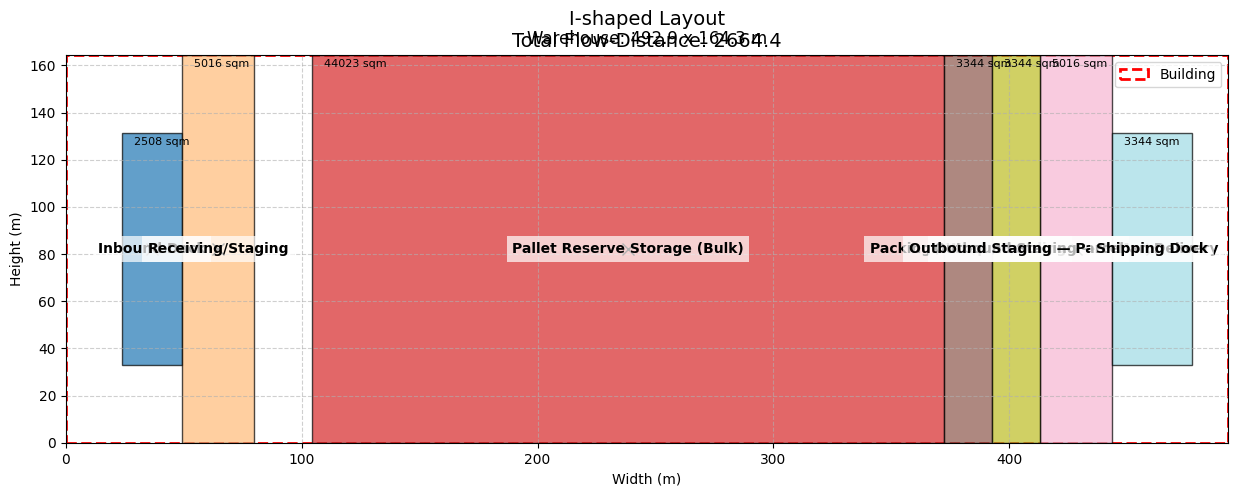

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.0001
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  300
NonConvex  2

Optimize a model with 364 rows, 240 columns and 1008 nonzeros
Model fingerprint: 0x0c527749
Model has 14 quadratic constraints
Variable types: 156 continuous, 84 integer (84 binary)
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+00, 3e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 3e+02]
  QRHS range       [3e+03, 5e+04]
Presolve removed 192 rows and 91 columns
Presolve time: 0.00s
Presolved: 186 rows, 150 columns, 588 nonzeros
Presolved model has 7 quadratic constraint(s)
Presolved model has 7 bi

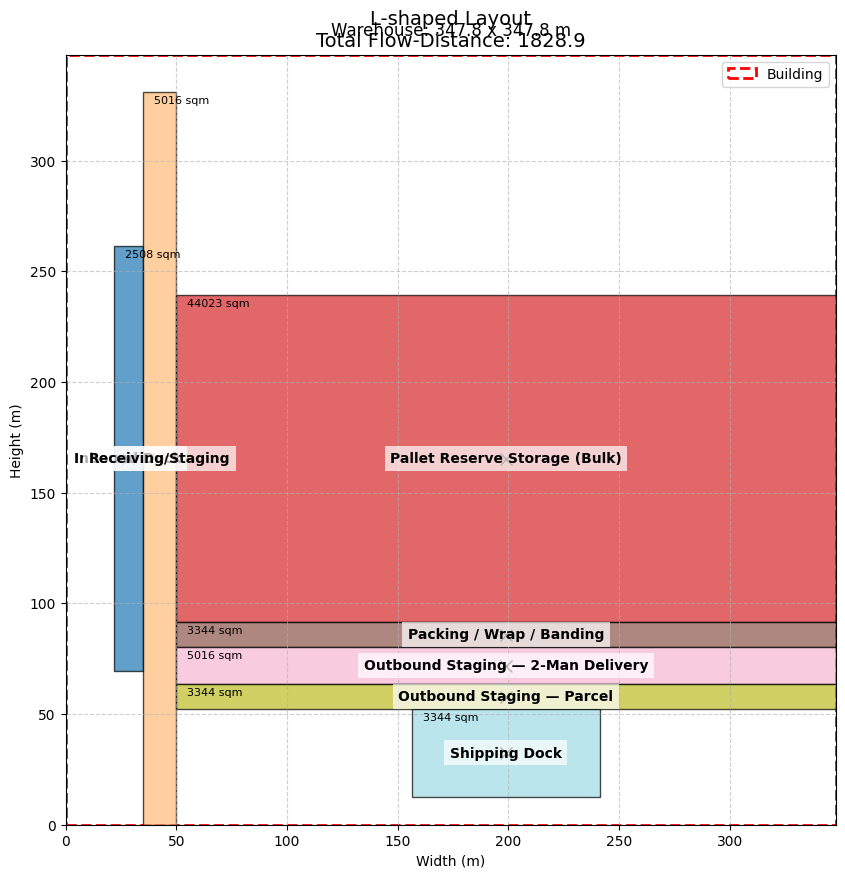

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.0001
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  300
NonConvex  2

Optimize a model with 364 rows, 240 columns and 1007 nonzeros
Model fingerprint: 0x420d4875
Model has 14 quadratic constraints
Variable types: 156 continuous, 84 integer (84 binary)
Coefficient statistics:
  Matrix range     [1e-01, 5e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+00, 3e+00]
  Bounds range     [1e+00, 5e+02]
  RHS range        [1e+00, 5e+02]
  QRHS range       [3e+03, 5e+04]
Presolve removed 194 rows and 95 columns
Presolve time: 0.00s
Presolved: 184 rows, 146 columns, 574 nonzeros
Presolved model has 7 quadratic constraint(s)
Presolved model has 7 bi

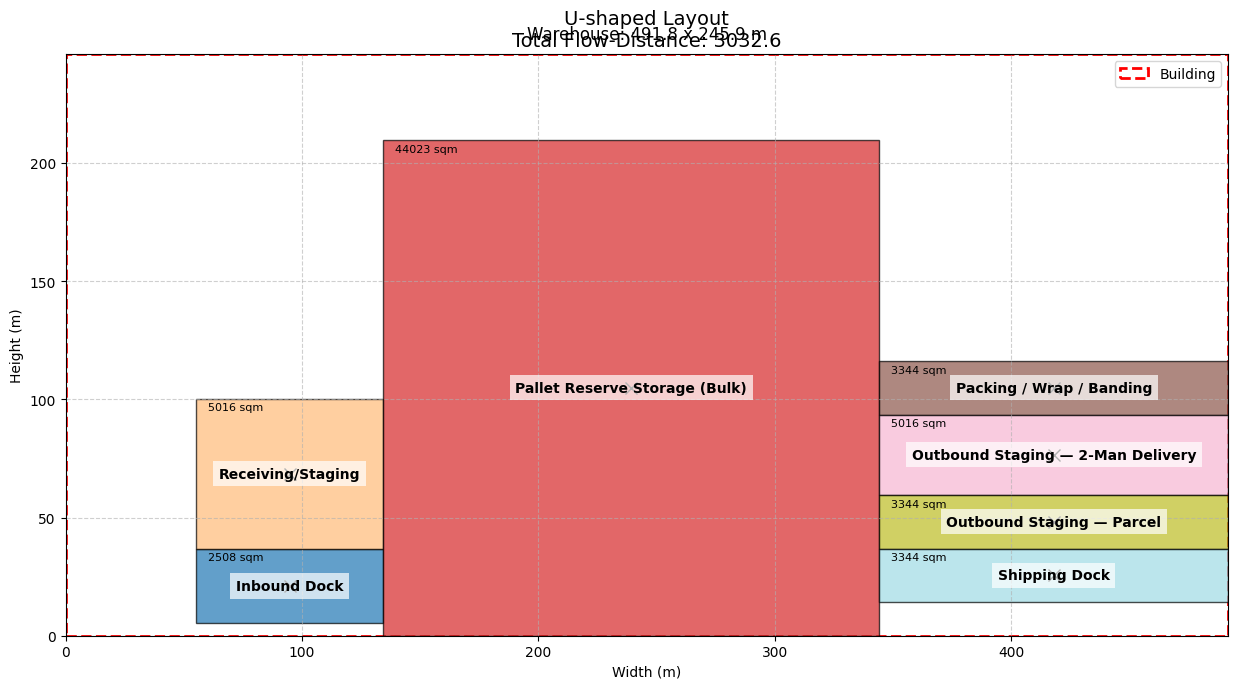

In [15]:


# -----------------------------
# USER PARAMETERS / INPUTS
# -----------------------------
# Department areas (sq_m) - scaled down by factor of 10 for more reasonable dimensions


# Calculate total area
total_area = sum(departments.values())


# Layout configurations with more reasonable dimensions
building_scale = 1.2  # Scale building size relative to total area
# ...existing code above where layout_configs is defined...

DOCK_BAND = 0.15  # % of building depth for front/back dock band

layout_configs = {
    "I-shaped": {
        "aspect_ratio": (3, 1),
        "dock_constraints": {
            # Opposite sides (straight flow)
            "Inbound Dock":  {"x_side": "left",  "y_range": (0.2, 0.8)},
            "Shipping Dock": {"x_side": "right", "y_range": (0.2, 0.8)}
        }
    },
    "L-shaped": {
        "aspect_ratio": (1, 1),
        "dock_constraints": {
            # Perpendicular: inbound on left wall, outbound on front (bottom)
            "Inbound Dock":  {"x_side": "left",  "y_range": (0.2, 0.8)},
            "Shipping Dock": {"y_side": "bottom", "x_range": (0.45, 0.95)}
        }
    },
    "U-shaped": {
        "aspect_ratio": (2, 1),
        "dock_constraints": {
            # Both on same front side, separated horizontally
            "Inbound Dock":  {"y_side": "bottom", "x_range": (0.00, 0.30)},
            "Shipping Dock": {"y_side": "bottom", "x_range": (0.70, 1.00)}
        }
    }
}


# ...existing code continues...

# ...existing code...
def solve_layout(layout_type):
    config = layout_configs[layout_type]
    aspect_ratio = config["aspect_ratio"]

    # Calculate building dimensions
    building_height = math.sqrt(total_area * building_scale * aspect_ratio[1] / aspect_ratio[0])
    building_width = building_height * aspect_ratio[0]

    model = gp.Model(f"warehouse_layout_{layout_type}")
    model.Params.NonConvex = 2
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.0001  # strict to prevent overlaps

    # Variables
    alpha, beta = {}, {}
    x_left, x_right, y_bottom, y_top = {}, {}, {}, {}
    width, height = {}, {}          # NEW width/height (always >= 0)
    d_alpha, d_beta = {}, {}

    # Building dimensions
    B_width = model.addVar(lb=0.9*building_width, ub=1.1*building_width, name="building_width")
    B_height = model.addVar(lb=0.9*building_height, ub=1.1*building_height, name="building_height")
    model.addConstr(B_width == aspect_ratio[0]/aspect_ratio[1] * B_height, name="aspect_ratio")

    # Department variables
    MIN_W = 5.0   # you can adjust these minima
    MIN_H = 5.0
    for d in dept_list:
        x_left[d] = model.addVar(lb=0, name=f"x_left_{d}")
        y_bottom[d] = model.addVar(lb=0, name=f"y_bottom_{d}")
        width[d] = model.addVar(lb=MIN_W, name=f"width_{d}")
        height[d] = model.addVar(lb=MIN_H, name=f"height_{d}")
        # Derived boundaries
        x_right[d] = model.addVar(lb=0, name=f"x_right_{d}")
        y_top[d] = model.addVar(lb=0, name=f"y_top_{d}")
        alpha[d] = model.addVar(name=f"alpha_{d}")
        beta[d] = model.addVar(name=f"beta_{d}")
        d_alpha[d], d_beta[d] = {}, {}
        for d2 in dept_list:
            d_alpha[d][d2] = model.addVar(lb=0, name=f"d_alpha_{d}_{d2}")
            d_beta[d][d2] = model.addVar(lb=0, name=f"d_beta_{d}_{d2}")

    model.update()

    # Tight Big-M values
    Mx = 1.1 * building_width
    My = 1.1 * building_height

    # Dock constraints
    for d, pos in config["dock_constraints"].items():
        if d in dept_list:
            # Horizontal side anchoring
            if "x_side" in pos:
                if pos["x_side"] == "left":
                    model.addConstr(x_right[d] <= 0.10 * B_width)
                elif pos["x_side"] == "right":
                    model.addConstr(x_left[d] >= 0.90 * B_width)
            # Vertical side anchoring
            if "y_side" in pos:
                if pos["y_side"] == "bottom":
                    model.addConstr(y_top[d] <= DOCK_BAND * B_height)
                elif pos["y_side"] == "top":
                    model.addConstr(y_bottom[d] >= (1 - DOCK_BAND) * B_height)
            # Ranges
            if "y_range" in pos:
                y_min, y_max = pos["y_range"]
                model.addConstr(y_bottom[d] >= y_min * B_height)
                model.addConstr(y_top[d]   <= y_max * B_height)
            if "x_range" in pos:
                x_min, x_max = pos["x_range"]
                model.addConstr(x_left[d]  >= x_min * B_width)
                model.addConstr(x_right[d] <= x_max * B_width)

    # Placement, dimension & area constraints (refactored)
    for d in dept_list:
        # Boundary box
        model.addConstr(x_left[d] >= 0)
        model.addConstr(y_bottom[d] >= 0)
        model.addConstr(x_right[d] <= B_width)
        model.addConstr(y_top[d] <= B_height)

        # Enforce orientation
        model.addConstr(x_right[d] == x_left[d] + width[d], name=f"def_xright_{d}")
        model.addConstr(y_top[d] == y_bottom[d] + height[d], name=f"def_ytop_{d}")

        # Area (bilinear but with positive factors only)
        area = departments[d]
        model.addConstr(width[d] * height[d] >= 0.95 * area, name=f"area_lb_{d}")
        model.addConstr(width[d] * height[d] <= 1.05 * area, name=f"area_ub_{d}")

        # Centroids
        model.addConstr(alpha[d] == x_left[d] + 0.5 * width[d], name=f"centroid_x_{d}")
        model.addConstr(beta[d] == y_bottom[d] + 0.5 * height[d], name=f"centroid_y_{d}")

    # Mutual non-overlap using 2 binaries per pair
    for i_idx in range(len(dept_list)):
        for j_idx in range(i_idx+1, len(dept_list)):
            i, j = dept_list[i_idx], dept_list[j_idx]
            eps = 1e-4

            # Direction binaries:
            # L_ij: i strictly left of j
            # R_ij: j strictly left of i
            # B_ij: i strictly below j
            # A_ij: j strictly below i
            L_ij = model.addVar(vtype=GRB.BINARY, name=f"L_{i}_{j}")
            R_ij = model.addVar(vtype=GRB.BINARY, name=f"R_{i}_{j}")
            B_ij = model.addVar(vtype=GRB.BINARY, name=f"B_{i}_{j}")
            A_ij = model.addVar(vtype=GRB.BINARY, name=f"A_{i}_{j}")

            # Exactly one spatial relation must hold
            model.addConstr(L_ij + R_ij + B_ij + A_ij == 1, name=f"one_dir_{i}_{j}")

            # Activate constraints via Big-M
            # i left of j
            model.addConstr(x_right[i] + eps <= x_left[j] + Mx*(1 - L_ij), name=f"left_{i}_{j}")
            # j left of i
            model.addConstr(x_right[j] + eps <= x_left[i] + Mx*(1 - R_ij), name=f"right_{i}_{j}")
            # i below j
            model.addConstr(y_top[i]   + eps <= y_bottom[j] + My*(1 - B_ij), name=f"below_{i}_{j}")
            # j below i
            model.addConstr(y_top[j]   + eps <= y_bottom[i] + My*(1 - A_ij), name=f"above_{i}_{j}")

    # Linearize centroid absolute differences
    for i in dept_list:
        for j in dept_list:
            model.addConstr(d_alpha[i][j] >= alpha[i] - alpha[j])
            model.addConstr(d_alpha[i][j] >= alpha[j] - alpha[i])
            model.addConstr(d_beta[i][j] >= beta[i] - beta[j])
            model.addConstr(d_beta[i][j] >= beta[j] - beta[i])

    # Objective
    obj = gp.quicksum(
        numeric_departments_matrix[i][j] * (d_alpha[i][j] + d_beta[i][j])
        for i in dept_list for j in dept_list if i != j
    )
    model.setObjective(obj, GRB.MINIMIZE)

    model.optimize()

    # Plot results (unchanged except width/height already consistent)
    if model.status in (GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL):
        print(f"\n--- {layout_type.upper()} LAYOUT ---")
        print(f"Building dimensions: {B_width.X:.1f} x {B_height.X:.1f} m")
        print(f"Total area: {B_width.X * B_height.X:.1f} sqm")
        print(f"Objective (total flow-distance): {model.ObjVal:.1f}")

        # ...existing code inside solve_layout, in the plotting section after creating fig, ax ...
        fig, ax = plt.subplots(figsize=(15,10))
        colors = plt.cm.get_cmap('tab20', len(dept_list))

        # Warehouse (building) outline
        building_outline = patches.Rectangle(
            (0, 0),
            B_width.X,
            B_height.X,
            facecolor='none',
            edgecolor='red',
            linewidth=2,
            linestyle='--',
            label='Building'
        )
        ax.add_patch(building_outline)
        ax.text(B_width.X/2, B_height.X + 0.02*B_height.X,
                f"Warehouse: {B_width.X:.1f} x {B_height.X:.1f} m",
                ha='center', va='bottom', fontsize=12)

        for idx, d in enumerate(dept_list):
            xl, xr = x_left[d].X, x_right[d].X
            yb, yt = y_bottom[d].X, y_top[d].X
            rect = patches.Rectangle((xl, yb), xr - xl, yt - yb,
                                     edgecolor='black', facecolor=colors(idx), alpha=0.7)
            ax.add_patch(rect)
            ax.text((xl + xr)/2, (yb + yt)/2, d, ha='center', va='center',
                    fontsize=10, fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            ax.plot((xl + xr)/2, (yb + yt)/2, 'kx', markersize=8)
            ax.text(xl + 5, yt - 5, f"{(xr - xl)*(yt - yb):.0f} sqm", fontsize=8)

        ax.set_xlim(0, B_width.X)
        ax.set_ylim(0, B_height.X)
        ax.set_aspect('equal')
        ax.set_title(f"{layout_type} Layout\nTotal Flow-Distance: {model.ObjVal:.1f}", fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xlabel("Width (m)")
        ax.set_ylabel("Height (m)")
        ax.legend(loc='upper right')
        plt.show()

    else:
        print(f"No feasible solution for {layout_type}, status: {model.status}")





# Run for all layouts
for layout_type in ["I-shaped", "L-shaped", "U-shaped"]:
    solve_layout(layout_type)
